In [1]:
import os
import pickle
import shutil 

import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from IPython import embed

Using MPI version 4.0, 1 processes


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [34]:
# set up simulation constants

resolution = 20

n_fusedSilica = 1.44
n_PDMS = 1.4
n_amorphousSi = 3.48

a = 0.680   # lattice period 

#pml_thickness = round(wavelength / 2,3)
pml_thickness = 0.780
height_pillar = 1.020
#width_PDMS = 1.560
width_fusedSilica = 0.780

cell_x = a
cell_y = a
cell_z = round(2*pml_thickness + height_pillar +  width_fusedSilica, 3)

#center_PDMS = round(0.5*(height_pillar + width_PDMS + pml_thickness) 
#                   + (pml_thickness + width_fusedSilica) - 0.5*cell_z, 3)
center_fusedSilica = round(0.5*(pml_thickness + width_fusedSilica) - 0.5*cell_z, 3)
center_pillar = round(pml_thickness + width_fusedSilica + 0.5*height_pillar
                    - 0.5*cell_z, 3) 

z_fusedSilica = pml_thickness + width_fusedSilica
#z_PDMS = height_pillar + width_PDMS + pml_thickness


In [35]:
geometry = [mp.Block(size=mp.Vector3(mp.inf,mp.inf,z_fusedSilica), 
                    center=mp.Vector3(0,0,center_fusedSilica),
                    material=mp.Medium(index=n_fusedSilica))]
            #mp.Block(size=mp.Vector3(mp.inf,mp.inf,z_PDMS),
                    #center=mp.Vector3(0,0,center_PDMS),
                    #material=mp.Medium(index=n_PDMS))]
k_point = mp.Vector3(0,0,0)

wavelength = 1.55
freq = 1 / wavelength

## initialize matrix for data collection ##
##########################################

num = 15 # this is the number of pillars we will build
data = np.zeros((3,num))

## set up and build source ##
############################

center_source = round(pml_thickness + width_fusedSilica*0.2 - 0.5*cell_z, 3) 
source_cmpt = mp.Ey

sources = [mp.Source(mp.ContinuousSource(frequency=freq),
                    component=source_cmpt,
                    center=mp.Vector3(0,0,center_source),
                    size=mp.Vector3(cell_x,cell_y,0))]


In [36]:
## Set up simulation ##
######################

cell_size = mp.Vector3(cell_x,cell_y,cell_z)
pml_layers = [mp.PML(thickness = pml_thickness, direction = mp.Z)]

if source_cmpt == mp.Ey:
    symmetries = [mp.Mirror(mp.X, phase=+1), #epsilon has mirror symmetry in x and y, phase doesn't matter
                  mp.Mirror(mp.Y, phase=-1)] #but sources have -1 phase when reflected normal to their direction
elif src_cmpt == mp.Ex:                      #use of symmetries important here, significantly speeds up sim
    symmetries = [mp.Mirror(mp.X, phase=-1),
                  mp.Mirror(mp.Y, phase=+1)]
elif src_cmpt == mp.Ez:
    symmetries = [mp.Mirror(mp.X, phase=+1),
                  mp.Mirror(mp.Y, phase=+1)]

sim = mp.Simulation(cell_size=cell_size,
                    #geometry=geometry,
                    sources=sources,
                    k_point=k_point,
                    boundary_layers=pml_layers,
                    symmetries=symmetries,
                    resolution=resolution)

nfreq = 1
df = 0
fr_center = round(0.5*cell_z - pml_thickness, 3)
fr = mp.FluxRegion(center=mp.Vector3(0,0,fr_center), 
            size=mp.Vector3(cell_x, cell_y, 0))

flux_object = sim.add_flux(freq, df, nfreq, fr)

In [37]:
sim.run(until=200)

initial_flux = mp.get_fluxes(flux_object)[0]     # initial fluxHoley metasurface
sim.reset_meep()

pbar = tqdm(total=num,leave=False)
for i,radius in enumerate(np.linspace(0.075,0.25,num=num)):
    geometry.append(mp.Cylinder(radius=radius,
                        height=height_pillar,
                        axis=mp.Vector3(0,0,1),
                        center=mp.Vector3(0,0,center_pillar),
                        material=mp.Medium(index=n_amorphousSi)))

    sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        sources=sources,
                        k_point=k_point,
                        boundary_layers=pml_layers,
                        symmetries=symmetries,
                        resolution=resolution)
    
    flux_object = sim.add_flux(freq, df, nfreq, fr)  

    sim.run(until=200)
    
    res = sim.get_eigenmode_coefficients(flux_object, [1], eig_parity=mp.ODD_Y)
    coeffs = res.alpha

    flux = abs(coeffs[0,0,0]**2)
    phase = np.angle(coeffs[0,0,0]) 
    
    data[0,i] = radius
    data[1,i] = flux
    data[2,i] = phase
    if(radius!=0.25):
        sim.reset_meep()
        print(f"i= {i},radius={radius}")
        geometry.pop(-1)
    pbar.update(1)
pbar.close()


-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.0023272 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 3.35 with resolution 20
time for set_epsilon = 0.0100119 s
-----------
run 0 finished at t = 200.0 (8000 timesteps)


  0%|                                                 | 0/15 [00:00<?, ?it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00144196 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 3.35 with resolution 20
     block, center = (0,0,-0.9)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     cylinder, center = (0,0,0.39)
          radius 0.075, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0359671 s
-----------


run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,1.21463) = 1.15476 after 14 iters
MPB solved for frequency_1(0,0,0.65673) = 0.631456 after 14 iters
MPB solved for frequency_1(0,0,0.671091) = 0.645157 after 9 iters
MPB solved for frequency_1(0,0,0.671095) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.671095)


  7%|██▋                                      | 1/15 [00:01<00:18,  1.29s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 0,radius=0.075
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00124884 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 3.35 with resolution 20
     block, center = (0,0,-0.9)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     cylinder, center = (0,0,0.39)
          radius 0.0875, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0363519 s
-----------


run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,1.21463) = 1.13179 after 20 iters
MPB solved for frequency_1(0,0,0.655345) = 0.622137 after 16 iters
MPB solved for frequency_1(0,0,0.679891) = 0.645143 after 17 iters
MPB solved for frequency_1(0,0,0.67991) = 0.645161 after 2 iters
MPB solved for frequency_1(0,0,0.67991) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.679910)


 13%|█████▍                                   | 2/15 [00:02<00:16,  1.24s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 1,radius=0.0875
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00103402 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 3.35 with resolution 20
     block, center = (0,0,-0.9)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     cylinder, center = (0,0,0.39)
          radius 0.1, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.034843 s
-----------


run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,1.21463) = 1.11297 after 15 iters
MPB solved for frequency_1(0,0,0.653281) = 0.613936 after 23 iters
MPB solved for frequency_1(0,0,0.687038) = 0.645116 after 7 iters
MPB solved for frequency_1(0,0,0.687087) = 0.645161 after 5 iters
MPB solved for frequency_1(0,0,0.687087) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.687087)


 20%|████████▏                                | 3/15 [00:03<00:14,  1.22s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 2,radius=0.09999999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000700951 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 3.35 with resolution 20
     block, center = (0,0,-0.9)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     cylinder, center = (0,0,0.39)
          radius 0.1125, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.03304 s
-----------


run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,1.21463) = 1.07269 after 19 iters
MPB solved for frequency_1(0,0,0.655991) = 0.601864 after 12 iters
MPB solved for frequency_1(0,0,0.704354) = 0.64502 after 15 iters
MPB solved for frequency_1(0,0,0.704513) = 0.645161 after 16 iters
MPB solved for frequency_1(0,0,0.704513) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.704513)


 27%|██████████▉                              | 4/15 [00:04<00:13,  1.21s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 3,radius=0.11249999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00112104 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 3.35 with resolution 20
     block, center = (0,0,-0.9)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     cylinder, center = (0,0,0.39)
          radius 0.125, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0295231 s
-----------


run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,1.21463) = 1.05985 after 19 iters
MPB solved for frequency_1(0,0,0.656558) = 0.597937 after 14 iters
MPB solved for frequency_1(0,0,0.70987) = 0.644969 after 13 iters
MPB solved for frequency_1(0,0,0.710089) = 0.645161 after 5 iters
MPB solved for frequency_1(0,0,0.710089) = 0.645161 after 11 iters
MPB solved for frequency_1(0,0,0.710089) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.710089)


 33%|█████████████▋                           | 5/15 [00:06<00:11,  1.20s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 4,radius=0.125
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00154901 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 3.35 with resolution 20
     block, center = (0,0,-0.9)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     cylinder, center = (0,0,0.39)
          radius 0.1375, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0374799 s
-----------


run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,1.21463) = 1.00685 after 20 iters
MPB solved for frequency_1(0,0,0.665721) = 0.586714 after 18 iters
MPB solved for frequency_1(0,0,0.734946) = 0.644681 after 24 iters
MPB solved for frequency_1(0,0,0.735525) = 0.645161 after 6 iters
MPB solved for frequency_1(0,0,0.735525) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.735525)


 40%|████████████████▍                        | 6/15 [00:07<00:10,  1.21s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 5,radius=0.13749999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00159693 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 3.35 with resolution 20
     block, center = (0,0,-0.9)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     cylinder, center = (0,0,0.39)
          radius 0.15, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.036222 s
-----------


run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,1.21463) = 0.979697 after 20 iters
MPB solved for frequency_1(0,0,0.677468) = 0.585472 after 17 iters
MPB solved for frequency_1(0,0,0.750251) = 0.644542 after 16 iters
MPB solved for frequency_1(0,0,0.751022) = 0.645161 after 10 iters
MPB solved for frequency_1(0,0,0.751022) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.751022)


 47%|███████████████████▏                     | 7/15 [00:08<00:09,  1.20s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 6,radius=0.15
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000841141 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 3.35 with resolution 20
     block, center = (0,0,-0.9)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     cylinder, center = (0,0,0.39)
          radius 0.1625, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0348971 s
-----------


run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,1.21463) = 0.938836 after 23 iters
MPB solved for frequency_1(0,0,0.707606) = 0.590648 after 12 iters
MPB solved for frequency_1(0,0,0.777726) = 0.644465 after 18 iters
MPB solved for frequency_1(0,0,0.778645) = 0.645161 after 15 iters
MPB solved for frequency_1(0,0,0.778645) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.778645)


 53%|█████████████████████▊                   | 8/15 [00:09<00:08,  1.19s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 7,radius=0.16249999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000684023 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 3.35 with resolution 20
     block, center = (0,0,-0.9)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     cylinder, center = (0,0,0.39)
          radius 0.175, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0359089 s
-----------


run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,1.21463) = 0.906658 after 21 iters
MPB solved for frequency_1(0,0,0.740051) = 0.598147 after 23 iters
MPB solved for frequency_1(0,0,0.803668) = 0.644521 after 9 iters
MPB solved for frequency_1(0,0,0.80456) = 0.645161 after 13 iters
MPB solved for frequency_1(0,0,0.80456) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.804560)


 60%|████████████████████████▌                | 9/15 [00:10<00:07,  1.19s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 8,radius=0.175
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00138807 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 3.35 with resolution 20
     block, center = (0,0,-0.9)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     cylinder, center = (0,0,0.39)
          radius 0.1875, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.042222 s
-----------


run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,1.21463) = 0.876162 after 20 iters
MPB solved for frequency_1(0,0,0.773985) = 0.605339 after 14 iters
MPB solved for frequency_1(0,0,0.830861) = 0.644601 after 10 iters
MPB solved for frequency_1(0,0,0.831685) = 0.645161 after 7 iters
MPB solved for frequency_1(0,0,0.831685) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.831685)


 67%|██████████████████████████▋             | 10/15 [00:12<00:05,  1.19s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 9,radius=0.1875
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000727892 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 3.35 with resolution 20
     block, center = (0,0,-0.9)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     cylinder, center = (0,0,0.39)
          radius 0.2, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.038408 s
-----------


run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,1.21463) = 0.854999 after 22 iters
MPB solved for frequency_1(0,0,0.800475) = 0.610687 after 12 iters
MPB solved for frequency_1(0,0,0.851826) = 0.644682 after 12 iters
MPB solved for frequency_1(0,0,0.852562) = 0.645161 after 7 iters
MPB solved for frequency_1(0,0,0.852562) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.852562)


 73%|█████████████████████████████▎          | 11/15 [00:13<00:04,  1.22s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 10,radius=0.19999999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00134802 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 3.35 with resolution 20
     block, center = (0,0,-0.9)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     cylinder, center = (0,0,0.39)
          radius 0.2125, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.041739 s
-----------


run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,1.21463) = 0.820227 after 20 iters
MPB solved for frequency_1(0,0,0.858846) = 0.62237 after 12 iters
MPB solved for frequency_1(0,0,0.895529) = 0.644921 after 19 iters
MPB solved for frequency_1(0,0,0.895924) = 0.645161 after 7 iters
MPB solved for frequency_1(0,0,0.895924) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.895924)


 80%|████████████████████████████████        | 12/15 [00:14<00:03,  1.23s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 11,radius=0.21249999999999997
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00143409 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 3.35 with resolution 20
     block, center = (0,0,-0.9)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     cylinder, center = (0,0,0.39)
          radius 0.225, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0426259 s
-----------


run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,1.21463) = 0.792896 after 24 iters
MPB solved for frequency_1(0,0,0.908579) = 0.629955 after 15 iters
MPB solved for frequency_1(0,0,0.934624) = 0.645047 after 14 iters
MPB solved for frequency_1(0,0,0.934823) = 0.645161 after 6 iters
MPB solved for frequency_1(0,0,0.934823) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.934823)


 87%|██████████████████████████████████▋     | 13/15 [00:15<00:02,  1.23s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 12,radius=0.22499999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00117683 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 3.35 with resolution 20
     block, center = (0,0,-0.9)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     cylinder, center = (0,0,0.39)
          radius 0.2375, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0410461 s
-----------


run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,1.21463) = 0.769493 after 25 iters
MPB solved for frequency_1(0,0,0.950363) = 0.634672 after 15 iters
MPB solved for frequency_1(0,0,0.96937) = 0.645103 after 12 iters
MPB solved for frequency_1(0,0,0.969477) = 0.645161 after 5 iters
MPB solved for frequency_1(0,0,0.969477) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.969477)


 93%|█████████████████████████████████████▎  | 14/15 [00:16<00:01,  1.22s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 13,radius=0.2375
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000813961 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 3.35 with resolution 20
     block, center = (0,0,-0.9)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     cylinder, center = (0,0,0.39)
          radius 0.25, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0403252 s
-----------


run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,1.21463) = 0.753303 after 26 iters
MPB solved for frequency_1(0,0,0.982211) = 0.637551 after 13 iters
MPB solved for frequency_1(0,0,0.996506) = 0.64513 after 14 iters
MPB solved for frequency_1(0,0,0.996565) = 0.645161 after 5 iters
MPB solved for frequency_1(0,0,0.996565) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,0.000000,0.996565)


     block, center = (0,0,-0.9)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     cylinder, center = (0,0,0.39)
          radius 0.25, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)


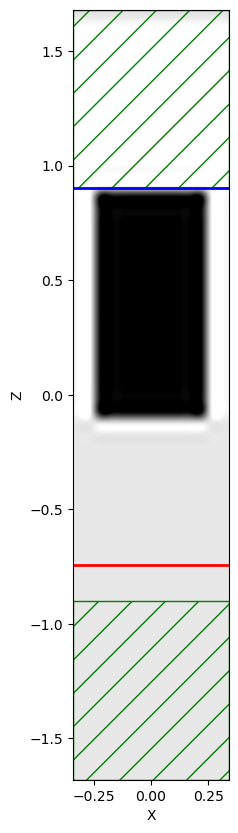

In [38]:
# plot an x-z cross section

plt.figure(figsize=(10,10))
plot_plane = mp.Volume(center=mp.Vector3(0,0.0*a,0),
                            size=mp.Vector3(a,0,cell_z))
field_func = lambda x: 20*np.log10(np.abs(x))
sim.plot2D(output_plane=plot_plane
           #fields=mp.Ey
           )
plt.grid(False)

/tmp/ipykernel_147156/2145056122.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


NameError: name 'radii' is not defined

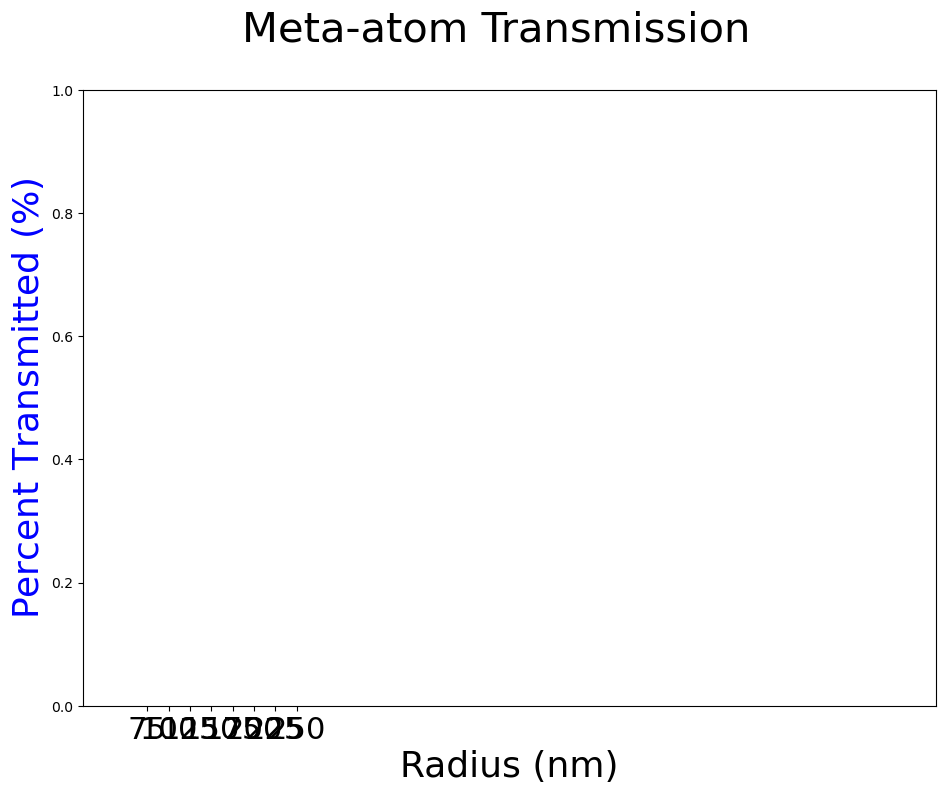

In [39]:
plt.style.use('seaborn-colorblind')

tickfontsize=22
labelfontsize=26
titlefontsize=30

fig,ax = plt.subplots(figsize=(11,8)) # may want to change. Also see DPI keyword

fig.suptitle("Meta-atom Transmission",fontsize=titlefontsize)

#ax.set_title("Transmission Magnitude",fontsize=titlefontsize)

ax.set_xlabel("Radius (nm)",fontsize=labelfontsize)
ax.set_xticks([0.075,0.100,0.125,0.150,0.175,0.200,0.225,0.250])
ax.set_xticklabels([75,100,125,150,175,200,225,250],fontsize=tickfontsize)
ax.set_ylim([0,1])
ax.set_ylabel(r'Percent Transmitted ($\%$)',fontsize=labelfontsize, color = 'blue')
ax.plot(radii,flux_list,'b',label='Transmission')
ax.tick_params(axis='y', labelcolor = 'blue')

ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0, 20,40,60,80,100],fontsize=tickfontsize)
#ax.set_yticks([0.6,0.7,0.8,0.9,1])
#ax.set_yticklabels([60,70,80,90,100],fontsize=tickfontsize)

twin1 = ax.twinx()

#ax[1].set_title("Transmission Phase",fontsize=titlefontsize)
#ax[1].set_xlabel("Radius (nm)",fontsize=labelfontsize)
#ax[1].set_xticks([0.075,0.100,0.125,0.150,0.175,0.200,0.225,0.250])
#ax[1].set_xticklabels([75,100,125,150,175,200,225,250],fontsize=tickfontsize)
twin1.set_ylim([-np.pi,np.pi])
twin1.set_ylabel(r'Phase Delay (rad)',fontsize=labelfontsize, color = 'red')
twin1.set_yticks([-np.pi, -(0.5*np.pi),0, np.pi / 2, np.pi])
twin1.set_yticklabels([r'-$\pi$',r'-$\frac{\pi}{2}$',r'0',r'$\frac{\pi}{2}$',r'$\pi$'],fontsize=tickfontsize+4)
twin1.plot(radii,phase_list,'r',label='Phase')
twin1.tick_params(axis='y', labelcolor = 'red')
#ax[1].legend(loc="upper right")
#plt.legend(loc="upper right")
plt.grid(False)
plt.tight_layout()